# Monte Carlo (MC) Methods

In this notebook, we will become familiar with the basic notion of Mote-Carlo methods:

1. Sampling probability distributions
2. MC estimate for $\pi$
3. Metropolis Hastings algorithm for the Ising model on a square lattice

## Sampling Custom Probability Distributions

Our first goal is to learn how to sample probability distributions using numpy. 

First, we define a Gaussian mixture in $1d$, and we visualize it. 

In [16]:
import numpy as np # load numpy library
import matplotlib.pyplot as plt # load plot library

# set the seed of the random number generator (required for reproducibility)
seed=0
np.random.seed(seed)

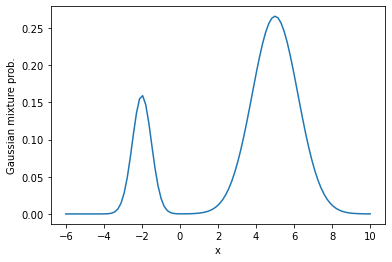

In [2]:
### define a Gaussian mixture in 1d

# mean and standard deviation
mu_1, sigma_1 = -2.0, 0.5 # Gaussian 1
mu_2, sigma_2 = +5.0, 1.2 # Gaussian 2

# mixture paramters (sum up to unity!)
alpha_1 = 0.2 
alpha_2 = 1.0 - alpha_1

# define mixture
my_distr = lambda x: alpha_1/np.sqrt(2*np.pi*sigma_1**2) * np.exp(-(x-mu_1)**2/(2*sigma_1**2)) \
                   + alpha_2/np.sqrt(2*np.pi*sigma_2**2) * np.exp(-(x-mu_2)**2/(2*sigma_2**2))


# visualize distribution
x=np.linspace(-6,10,100)
y=my_distr(x)

plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('Gaussian mixture prob.')
plt.show()


In order to sample from this distribution, we first need to discretize it (numerical programs work (mostly) with numbers, not expressions). To this end, we sample $100$ points uniformly at random, and evaluate the distribution on these points.

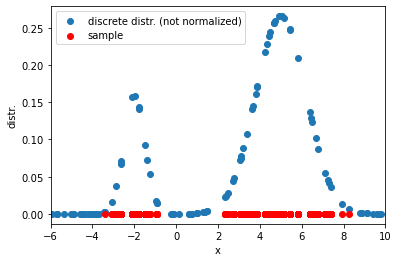

In [3]:
# sample M random numbers uniformly from the interval $[-6.0,+10.0]$
M=100
x_random=np.random.uniform(-6.0,10.0,M)

# evaluate distribution at these random points
y_random=my_distr(x_random)

# define discrete distribution as an array (keep in mind the normalization!)
my_distr_approx=y_random/np.sum(y_random)

# create a sample fro the Gaussian mixture (REQUIRES distribution to be normalized!)
N=1000 # sample size
x_sample=np.random.choice(x_random,p=my_distr_approx,size=N)


# plot result
plt.clf() # clear figure
plt.scatter(x_random,y_random,label='discrete distr. (not normalized)') # plot the random points
plt.scatter(x_sample,0*x_sample,color='r',label='sample') # plot the sample only
plt.xlim(-6.0,10.0) # fix plot limits
plt.legend()
plt.xlabel('x')
plt.ylabel('distr.')
plt.show()


To recover empirically the original distribution from the sample, we can build a histogram:

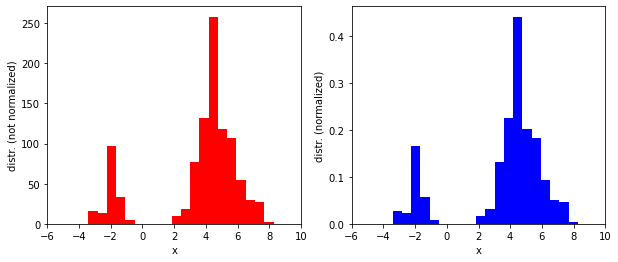

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))  # 1 row, 2 columns

hist_object_1 = ax1.hist(x_sample,bins=20,color='red')
ax1.set_xlim(-6.0,10.0)
ax1.set_xlabel('x')
ax1.set_ylabel('distr. (not normalized)')

hist_object_2 = ax2.hist(x_sample,bins=20,color='blue',density=True)
ax2.set_xlim(-6.0,10.0)
ax2.set_xlabel('x')
ax2.set_ylabel('distr. (normalized)')

plt.show()

## Monte Carlo Estimate of $\pi$

Consider a square of side $d$, and inscribe a circle of radius $r=d/2$ in it. The ratio of the area of the circle to the area of the square is

$$ \frac{A_\mathrm{circle}}{A_\mathrm{square}} = \frac{\pi}{4}$$

which is propoertional to $\pi$. Therefore, if we can use MC sampling to estimate the area of the circle and the square separately, we can get an approximation to the numerical value of $\pi$. 


Below, we generate random points $(x,y)$ from the interval $[-1,1]\times[-1,1]$ which defines the square. For each point $(x,y)$ from the square, we can compute the square distance to the origin $(0,0)$: 

$$D^2=x^2+y^2$$

If $D^2<1$, then $(x,y)$ lies within the circle, otherwise it does not.   

An estimate of the ratio of areas can then be obtained by counting the number of randomly chosen points which belong to the circle, and dividing this by the total number of points, restricted to the square. 

The procedure can be summarized in the following steps:
1. set a fixed number of Monte Carlo points to run the simulation for
2. initialize counters for the number of points in the circle and the square, and set them to zero
    1. draw a random point $(x,y)$ inside the square (propose a state)
    2. compute the squared distance $D^2=x^2+y^2$
    3. if $D<1$, increment the circle counter (reacall: accept/reject proposed state)
    4. increment the square counter
3. repeat steps 2A-2D until the number of MC points has been reached
4. estimate the value of $\pi$ from the ratio of the counters. 

In [5]:
def MC_pi(N_MC_points=10000):
    """
    N_MC_points: int
        number of MC points to estimate the value of $\pi$
    """
    # initialize counters
    N_circle_points=0
    N_square_points=0

    j=0 # set auxiliary counter (can be avoided by using a for-loop)
    while j<N_MC_points:
        # draw random numbers on [-1,1]^2
        x, y =np.random.uniform(low=-1.0, high=+1.0, size=(2,))
        # compute square distance
        D2=x**2+y**2
        # accept point if it lies inside the circle
        if D2<1:
            # increment circle counter
            N_circle_points+=1
        # increment square counter
        N_square_points+=1
        
        j+=1

    # compute ratio approximating $\pi$
    return 4.0*N_circle_points/N_square_points
    
# compute estimate
pi_est = MC_pi(N_MC_points=10000)
print("pi estimate is {0:0.5f} with absolute error {1:0.5}.".format(pi_est, np.abs(np.pi-pi_est)))

pi estimate is 3.12520 with absolute error 0.016393.


We can loop over a logarithmic grid of MC points to see how the estimate improves:

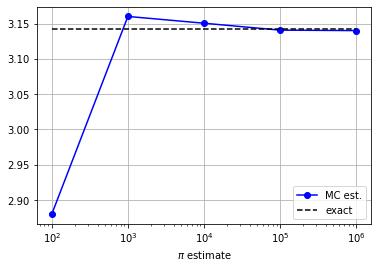

In [6]:
# loop over different order of magnitudes of MC points
N_MCs=np.logspace(2,6,5)

# preallocate data array
pi_approx=np.zeros(N_MCs.shape, dtype=np.float64)
# find $\pi$-estimates
for i,N_MC_points in enumerate(N_MCs):
    pi_approx[i]=MC_pi(N_MC_points)
    
    
# plot results
plt.plot(N_MCs, pi_approx, '-ob', label='MC est.')
plt.plot(N_MCs, np.pi*np.ones(N_MCs.shape), '--k', label='exact')
plt.xscale('log') # plot x-axis on a log scale
plt.xlabel('$N_\mathrm{MC}$')
plt.xlabel('$\pi$ estimate')
plt.legend()
plt.grid()
plt.show()

## Metropolis Hastings Algorithm for the 2D Ising Model

The energy function of the classical Ising model is given by

$$ H(S) = J\sum_{\langle ij\rangle} S_i S_j,\qquad S_i\in\{\pm 1\} $$

where the lattice site indices  $i,j$ run over all nearest neighbors of a square lattice of $L\times L$ lattice sites, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. 

Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit ($L\to\infty$) from an ordered ferromagnet with all spins aligned, to a disordered phase at the critical temperature  $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. 

For any finite system size ($L<\infty$), this critical point is expanded to a critical region around $T_c$.

In [7]:
import scipy.sparse as sp

# model parameters
L=40 # linear system size
J=-1.0 # Ising coupling

N_sites=L*L # total number of lattice sites
sites = np.arange(N_sites,dtype=np.int32) # sites [0,1,2,....]

x = sites%L # x positions for sites
y = sites//L # y positions for sites

T_x = (x+1)%L + L*y # translation along x-direction
T_y = x+L*((y+1)%L) # translation along y-direction

# build 2D Ising model with nn interactions
h_2D_nn = np.array( [ [J,i,T_x[i]] for i in range(N_sites)] + [ [J,i,T_y[i]] for i in range(N_sites)] )
H=sp.csr_matrix((h_2D_nn[:,0], (h_2D_nn[:,1], h_2D_nn[:,2])), shape=(N_sites, N_sites))

def energy(s):
    return np.dot(s,H.dot(s))

Let's visualize a random spin configuration:

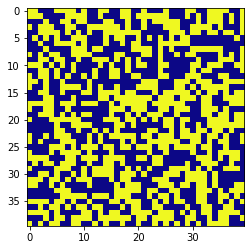

In [8]:
S=2*np.random.randint(0,2,size=N_sites)-1
S=S.reshape(L,L)

plt.imshow(S,vmin=-1., vmax=1., cmap='plasma_r')
plt.show()

Next, we want to sample configurations from the Boltzmann distribution
$$p(S)\propto \exp(-H(S)/T)$$
at a temperature $T=\beta^{-1}$. Note that we cannot normalize this distribution because there are a total of $2^{L^2}$ configurations, which is about $10^{480}$ (!!!) for $L=40$.

To do this, we will implement a version of the Metropolis-Hastings algorithm discussed in class. 

In [9]:
# simulation parameters
N_MC_points=100
corr_time=N_sites
thermalization_time=10*N_sites

# preallocate data
states=np.zeros((N_MC_points,N_sites),dtype=int)
energies=np.zeros((N_MC_points,),dtype=np.float64)

def sample(T):
    """
    This function generates a sample of spin configurations at a fixed temperature T.
    
    """
    
    
    # define initial state
    s=2*np.random.randint(0,2,size=N_sites)-1
    # compute energy
    E_s=energy(s)
    
    # compute inverse temperature
    beta=1.0/T

    j,k=0,0 # auxiliary counters
    while k<N_MC_points:
        
        t=s.copy() # copy current spin tate
        
        # propose a new spin state t
        i=np.random.randint(0,N_sites,)
        t[i]*=-1
        
        # compute energy
        E_t=energy(t)
        delta_E=E_t-E_s

        # accept/reject update
        eps=np.random.uniform(0.0,1.0)
        if eps<=np.exp(-beta*delta_E): # accept
            s=t.copy()
            E_s=E_t.copy()

        # measure (i.e. record state in the sample)
        if j%corr_time==0 and j>thermalization_time:
            states[k]=s
            energies[k]=E_s
            k+=1

        j+=1
        
    return states, energies

In [10]:
T = 2.0 # choose temperature: recall: p(S) ~ exp(-H(S)/T)
states, energies = sample(T)

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation

cmap_args=dict(vmin=-1., vmax=1., cmap='plasma_r')
fig, ax = plt.subplots()

im = ax.imshow(states[0].reshape(L,L), **cmap_args)

def animate(i):
    im.set_data(states[i+1].reshape(L,L),)
    ax.set_title('sample number: i={0:d}'.format(i+1))

_m=8 # show every _m-th frame
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=np.arange(1,len(states),_m)+_m)

plt.show()

<IPython.core.display.Javascript object>

Last, we want to look at arbitrary spin configurations sampled at different temperatures $T$. 

To do this, we create a set of temperatures, and then use Metropolis-Hastings to generate a sample of spin configurations at every temperature. We then plot the last three spin configs present in the sample for every $T$.

T=1.50, <E>=-1.7241, <M>=0.2729


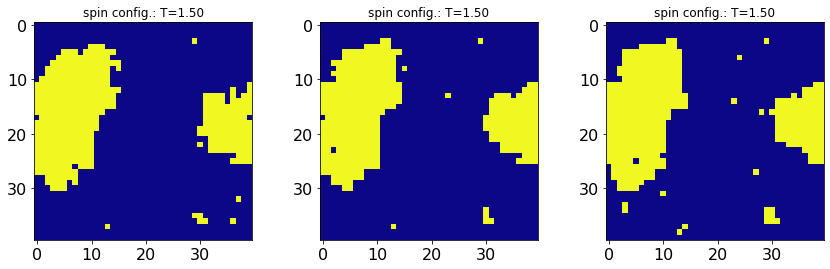

T=2.00, <E>=-1.4935, <M>=-0.4012


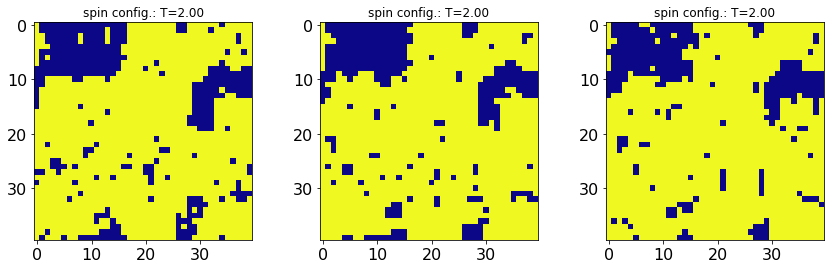

T=2.50, <E>=-1.0888, <M>=0.0658


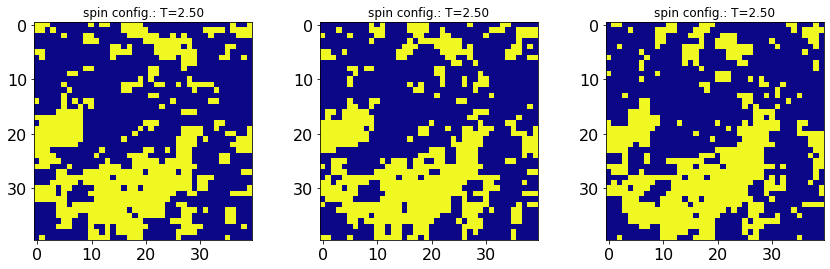

T=3.00, <E>=-0.8095, <M>=0.0413


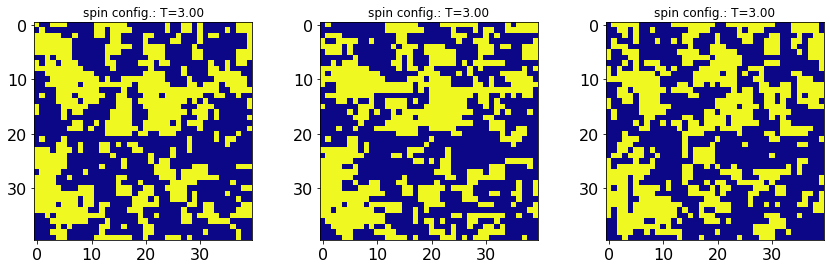

T=3.50, <E>=-0.6711, <M>=0.0036


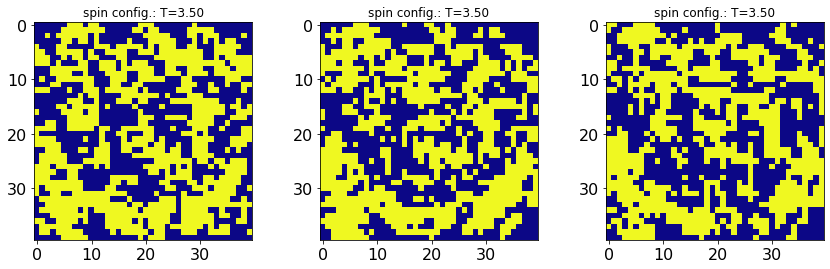

T=4.00, <E>=-0.5513, <M>=0.0129


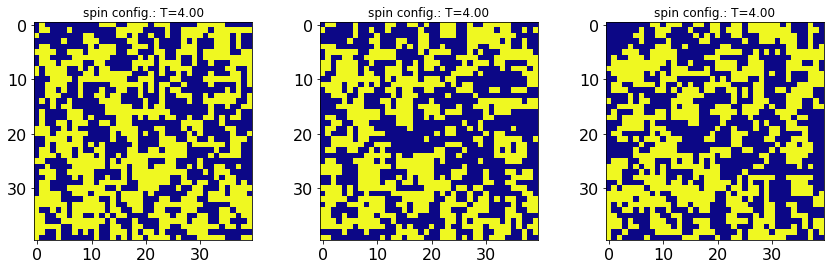

In [14]:
%matplotlib inline

# define set of temperatures across the critical point
T_vec=np.linspace(1.5,4.0,num=6)

# preallocate data
E_density=np.zeros_like(T_vec)
M_density=np.zeros_like(T_vec)

for T_counter, T in enumerate(T_vec):
    
    # run MC sampler
    states, energies = sample(T)
    
    # compute mean energy and magnetization
    e_density=np.mean(energies)/N_sites
    m_density=np.mean(states,)
    
    E_density[T_counter]=e_density
    M_density[T_counter]=m_density

    print("T={0:0.2f}, <E>={1:0.4f}, <M>={2:0.4f}".format(T, e_density, m_density) )
          
          
    # plot data
          
    # get last three states in the Markov chain  
    S_0=states[-1].reshape(L,L)
    S_1=states[-2].reshape(L,L)
    S_2=states[-3].reshape(L,L)
          
    # set colorbar parameters
    cmap_args=dict(vmin=-1., vmax=1., cmap='plasma_r')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(S_0,**cmap_args)
    axarr[0].set_title('spin config.: T={0:0.2f}'.format(T))
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(S_1,**cmap_args)
    axarr[1].set_title('spin config.: T={0:0.2f}'.format(T))
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(S_2,**cmap_args)
    axarr[2].set_title('spin config.: T={0:0.2f}'.format(T))
    axarr[2].tick_params(labelsize=16)
     
    fig.subplots_adjust(right=2.0)
    
    plt.show()